# Exploratory Data Analysis
---

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ranksums
from config import DATA_DIR
from data import get_collision_data

In [2]:
raw_df = get_collision_data()
processed_df = pd.read_csv(DATA_DIR / 'processed_data.csv')

In [3]:
def plot_ages(df):
    ages = df.INVAGE.value_counts()
    idx = ages.rename(index={'5 to 9': '05 to 9'}).index.sort_values().tolist()
    idx[1] = '5 to 9'
    ages = ages.reindex(idx)
    plt.bar(idx, ages)
    plt.xlabel('Age groups')
    plt.ylabel('Count')
    plt.xticks(rotation=60)
    plt.show()
    ages = np.around(ages / sum(ages), 3)
    display(pd.DataFrame(ages.rename('Proportion')))

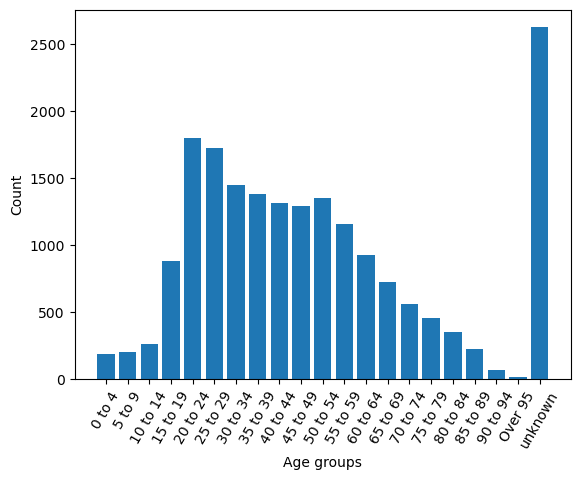

,Proportion
INVAGE,
0 to 4,0.010
5 to 9,0.011
10 to 14,0.014
15 to 19,0.047
20 to 24,0.095
25 to 29,0.091
30 to 34,0.076
35 to 39,0.073
40 to 44,0.069


In [4]:
plot_ages(raw_df)

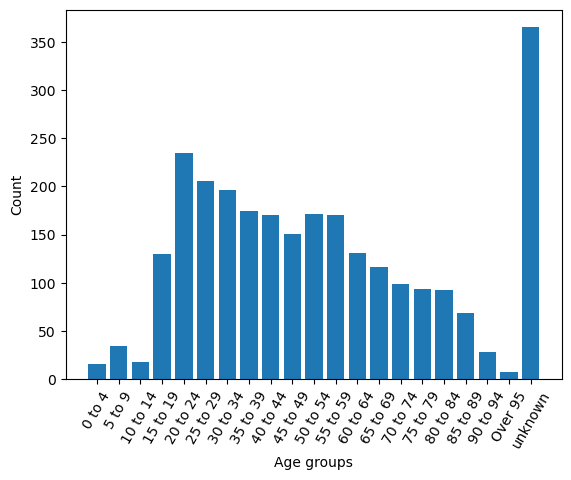

,Proportion
INVAGE,
0 to 4,0.006
5 to 9,0.013
10 to 14,0.007
15 to 19,0.049
20 to 24,0.088
25 to 29,0.077
30 to 34,0.073
35 to 39,0.065
40 to 44,0.064


In [5]:
fatal = raw_df.query('ACCLASS == "Fatal"')
plot_ages(fatal)

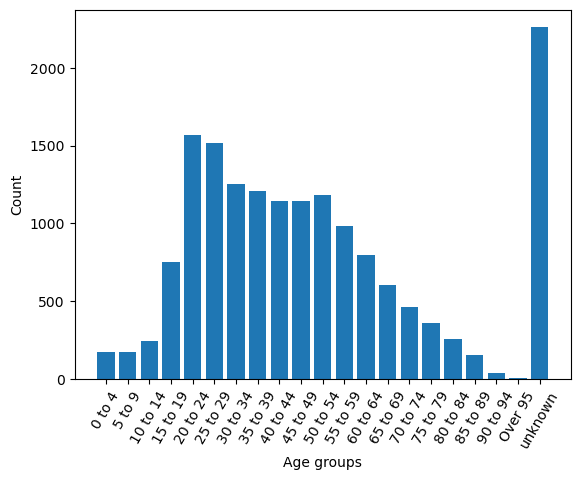

,Proportion
INVAGE,
0 to 4,0.011
5 to 9,0.011
10 to 14,0.015
15 to 19,0.046
20 to 24,0.096
25 to 29,0.093
30 to 34,0.077
35 to 39,0.074
40 to 44,0.070


In [6]:
nonfatal = raw_df.query('ACCLASS != "Fatal"')
plot_ages(nonfatal)

### Observations
- Seniors are overrepresented in the fatality class (as expected)
- Large proportion of unknown ages (likely sample bias)
- Marginal differences between all serious crashes and fatal crashes for infants
    - Perhaps due to added safety precautions (i.e. car seats, in the backseat)

In [48]:
def make_summary(feature: str):
    all = processed_df[feature].value_counts()
    fatal = processed_df.query('ACCLASS == "Fatal"')[feature].value_counts().reindex(all.index, fill_value=0)

    if processed_df[feature].dtype == 'float64':
        stat, p = ranksums(all, fatal)
        print(f'Wilcoxon rank-sum p-value: {p:.5f}')
        
        plt.boxplot(all)
        plt.boxplot(fatal)
        plt.ylim([0.75,1.25])
        return
    else:
        stat, p, dof, expected_freq = chi2_contingency(counts, correction=True)
        print(f'chi-square p-value: {p:.5f}')
    
    # Plot
    fig, axs = plt.subplots(2, 1)
    axs[0].barh(all.index, all)
    axs[1].barh(fatal.index, fatal)
    axs[1].set_xlabel('Count')
    for i in range(2):
        axs[i].set_ylabel(feature)

    # Summary tables
    all_proportions = np.around(all / sum(all), 3)
    fatal_proportions = np.around(fatal / sum(fatal), 3)
    counts = pd.merge(all, fatal, left_index=True, right_index=True).rename(columns={'count_x': 'All', 'count_y': 'Fatal'})
    proportions = pd.merge(all_proportions, fatal_proportions, left_index=True, right_index=True).rename(columns={'count_x': 'All', 'count_y': 'Fatal'})
    proportions['Delta'] = proportions['Fatal'] - proportions['All']
    display(counts)
    display(proportions)


,All,Fatal
ROAD_CLASS,,
Major Arterial,4694,660
Minor Arterial,1135,145
Collector,434,53
Local,426,57
Expressway,107,27
Expressway Ramp,22,6
Other,17,3


,All,Fatal,Delta
ROAD_CLASS,,,
Major Arterial,0.687,0.694,0.007
Minor Arterial,0.166,0.152,-0.014
Collector,0.063,0.056,-0.007
Local,0.062,0.060,-0.002
Expressway,0.016,0.028,0.012
Expressway Ramp,0.003,0.006,0.003
Other,0.002,0.003,0.001


chi-square p-value: 0.05948


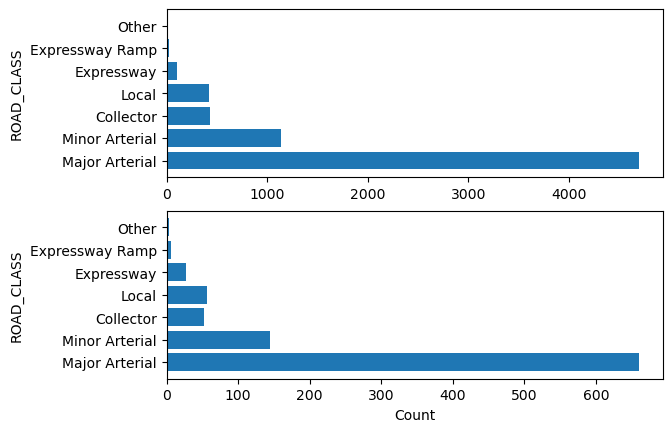

In [8]:
make_summary('ROAD_CLASS')

### Observations
- Expressways and Expressway ramps are overrepresented in fatalities

,All,Fatal
DISTRICT,,
Toronto and East York,2373,248
Etobicoke York,1574,223
Scarborough,1500,272
North York,1388,208


,All,Fatal,Delta
DISTRICT,,,
Toronto and East York,0.347,0.261,-0.086
Etobicoke York,0.230,0.234,0.004
Scarborough,0.219,0.286,0.067
North York,0.203,0.219,0.016


chi-square p-value: 0.00000


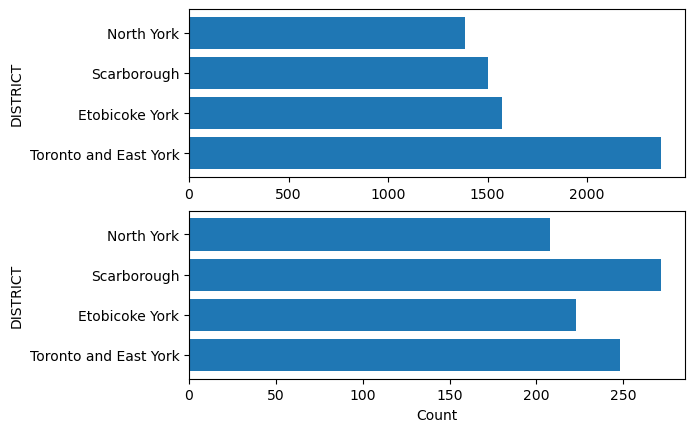

In [9]:
make_summary('DISTRICT')

### Observations
- Scarborough overrepresented
- Toronto and East York underrepresented

,All,Fatal
TRAFFCTL,,
No Control,3348,536
Traffic Signal,2799,340
Stop Sign,545,63
Pedestrian Crossover,83,11
Other,60,1


,All,Fatal,Delta
TRAFFCTL,,,
No Control,0.490,0.564,0.074
Traffic Signal,0.410,0.358,-0.052
Stop Sign,0.080,0.066,-0.014
Pedestrian Crossover,0.012,0.012,0.000
Other,0.009,0.001,-0.008


chi-square p-value: 0.00012


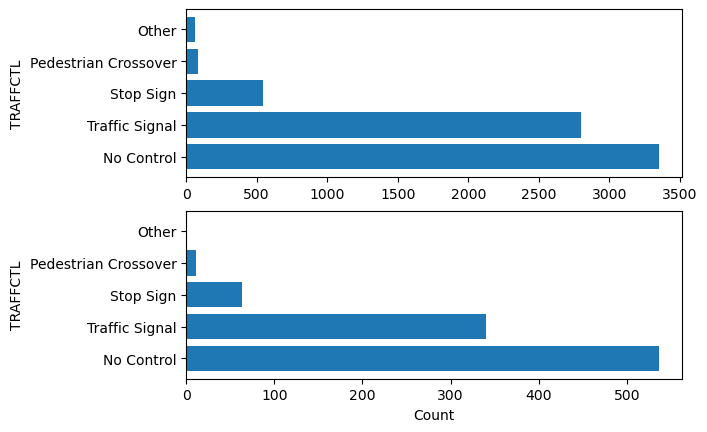

In [10]:
make_summary('TRAFFCTL')

### Observations
- Stop Sign underrepresented ✅: likely due to slower speeds at stop signs
- Traffic Signal ✅:
- No Control: ⚠️
- Pedestrian Crossover: 💛

In [11]:
processed_df.head()

,ROAD_CLASS,DISTRICT,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,NEIGHBOURHOOD_158,YEAR,MONTH_sin,MONTH_cos,DOW_sin,DOW_cos,HOUR_sin,HOUR_cos,INVAGE_00to04,INVAGE_05to09,INVAGE_10to14,INVAGE_15to19,INVAGE_20to24,INVAGE_25to29,INVAGE_30to34,INVAGE_35to39,INVAGE_40to44,INVAGE_45to49,INVAGE_50to54,...,INVAGE_60to64,INVAGE_65to69,INVAGE_70to74,INVAGE_75to79,INVAGE_80to84,INVAGE_85to89,INVAGE_90to94,INVAGE_Over95,INVAGE_unknown,NUMPERSONS,MANOEUVER_ChangingLanes,MANOEUVER_GoingAhead,MANOEUVER_MakingUTurn,MANOEUVER_Merging,MANOEUVER_Other,MANOEUVER_Overtaking,MANOEUVER_Parked,MANOEUVER_PullingAwayfromShoulderorCurb,MANOEUVER_PullingOntoShoulderortowardCurb,MANOEUVER_Reversing,MANOEUVER_SlowingorStopping,MANOEUVER_Stopped,MANOEUVER_TurningLeft,MANOEUVER_TurningRight,MANOEUVER_Unknown,DRIVACT_DisobeyedTrafficControl,DRIVACT_DrivingProperly,DRIVACT_ExceedingSpeedLimit,DRIVACT_FailedtoYieldRightofWay,DRIVACT_FollowingtooClose,DRIVACT_ImproperLaneChange,DRIVACT_ImproperPassing,DRIVACT_ImproperTurn,DRIVACT_Lostcontrol,DRIVACT_Other,DRIVACT_SpeedtooFastForCondition,DRIVACT_SpeedtooSlow,DRIVACT_WrongWayonOneWayRoad,NEAREST_HOSPITAL,DIST_TO_HOS
0,Major Arterial,Toronto and East York,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,False,False,True,False,False,False,False,True,True,True,False,True,False,Woodbine-Lumsden,2006,0.0,1.0,-0.781831,0.623490,0.707107,0.707107,0,0,0,2,2,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,8,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,Michael Garron Hospital,1690.092558
1,Major Arterial,Toronto and East York,No Control,Snow,"Dark, artificial",Slush,Non-Fatal Injury,SMV Other,False,False,True,False,False,False,False,True,False,False,False,False,False,Woodbine Corridor,2006,0.0,1.0,-0.781831,0.623490,0.707107,0.707107,0,0,1,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Michael Garron Hospital,1319.054409
2,Major Arterial,Toronto and East York,No Control,Other,"Dark, artificial",Wet,Non-Fatal Injury,Pedestrian Collisions,True,False,True,False,False,False,False,False,False,False,False,False,False,Kensington-Chinatown,2006,0.0,1.0,0.000000,1.000000,0.965926,-0.258819,0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,University Health Network - Toronto Western,64.433565
3,Major Arterial,Toronto and East York,Traffic Signal,Rain,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,True,False,True,False,False,False,False,False,False,False,False,False,False,Dufferin Grove,2006,0.0,1.0,0.974928,-0.222521,-0.866025,0.500000,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,University Health Network - Toronto Western,2353.035635
4,Major Arterial,North York,Traffic Signal,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,True,False,True,False,False,False,False,False,False,False,False,False,False,Don Valley Village,2006,0.0,1.0,-0.433884,-0.900969,-0.500000,0.866025,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,North York General Hospital - General Site,2166.055889


,All,Fatal
VISIBILITY,,
Clear,5872,817
Rain,752,98
Snow,123,13
Other,41,18
"Fog, Mist, Smoke, Dust",18,3
Freezing Rain,17,1
Drifting Snow,8,0
Strong wind,4,1


,All,Fatal,Delta
VISIBILITY,,,
Clear,0.859,0.859,0.000
Rain,0.110,0.103,-0.007
Snow,0.018,0.014,-0.004
Other,0.006,0.019,0.013
"Fog, Mist, Smoke, Dust",0.003,0.003,0.000
Freezing Rain,0.002,0.001,-0.001
Drifting Snow,0.001,0.000,-0.001
Strong wind,0.001,0.001,0.000


chi-square p-value: 0.00264


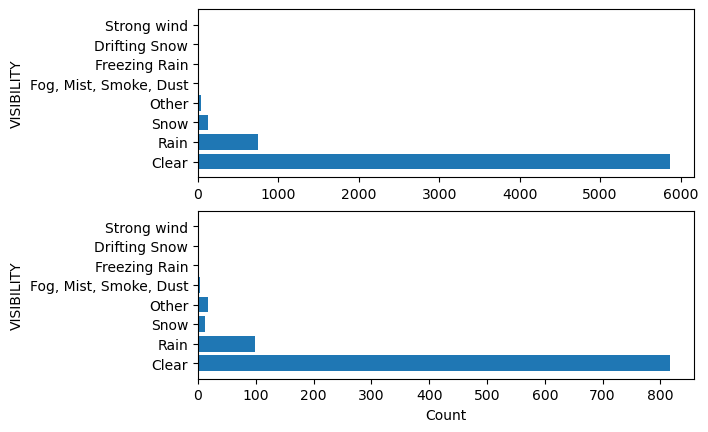

In [12]:
make_summary('VISIBILITY')

,All,Fatal
LIGHT,,
Daylight,3887,476
"Dark, artificial",1352,209
Dark,1263,215
"Dusk, artificial",94,11
Dusk,91,14
"Daylight, artificial",63,8
"Dawn, artificial",42,10
Dawn,40,6
Other,3,2


,All,Fatal,Delta
LIGHT,,,
Daylight,0.569,0.501,-0.068
"Dark, artificial",0.198,0.220,0.022
Dark,0.185,0.226,0.041
"Dusk, artificial",0.014,0.012,-0.002
Dusk,0.013,0.015,0.002
"Daylight, artificial",0.009,0.008,-0.001
"Dawn, artificial",0.006,0.011,0.005
Dawn,0.006,0.006,0.000
Other,0.000,0.002,0.002


chi-square p-value: 0.00346


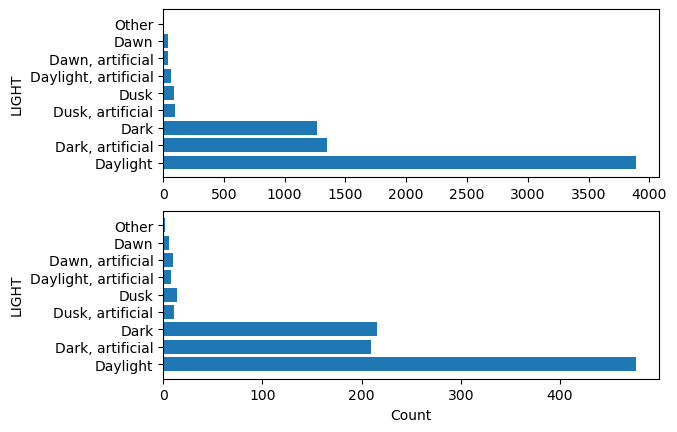

In [13]:
make_summary('LIGHT')

,All,Fatal
RDSFCOND,,
Dry,5466,753
Wet,1174,164
Other,57,20
Loose Snow,54,5
Slush,35,3
Ice,24,2
Packed Snow,18,4
Loose Sand or Gravel,6,0
Spilled liquid,1,0


,All,Fatal,Delta
RDSFCOND,,,
Dry,0.800,0.792,-0.008
Wet,0.172,0.172,0.000
Other,0.008,0.021,0.013
Loose Snow,0.008,0.005,-0.003
Slush,0.005,0.003,-0.002
Ice,0.004,0.002,-0.002
Packed Snow,0.003,0.004,0.001
Loose Sand or Gravel,0.001,0.000,-0.001
Spilled liquid,0.000,0.000,0.000


chi-square p-value: 0.02718


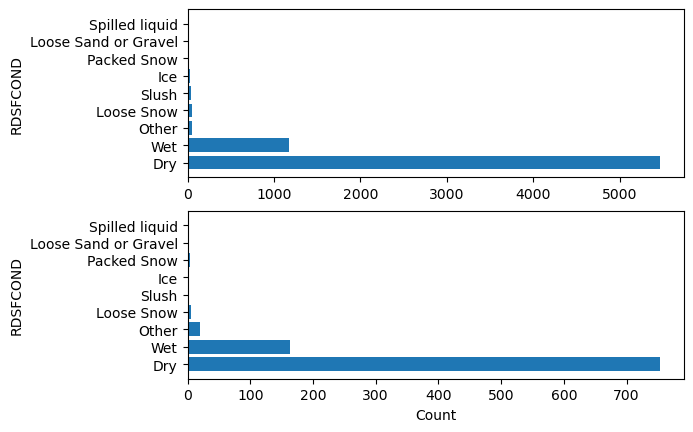

In [14]:
make_summary('RDSFCOND')

,All,Fatal
PEDESTRIAN,,
False,3788,413
True,3047,538


,All,Fatal,Delta
PEDESTRIAN,,,
False,0.554,0.434,-0.12
True,0.446,0.566,0.12


chi-square p-value: 0.00000


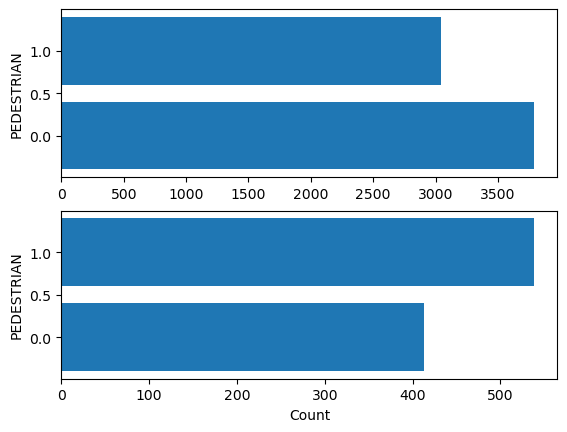

In [15]:
make_summary('PEDESTRIAN')

,All,Fatal
CYCLIST,,
False,5991,905
True,844,46


,All,Fatal,Delta
CYCLIST,,,
False,0.877,0.952,0.075
True,0.123,0.048,-0.075


chi-square p-value: 0.00000


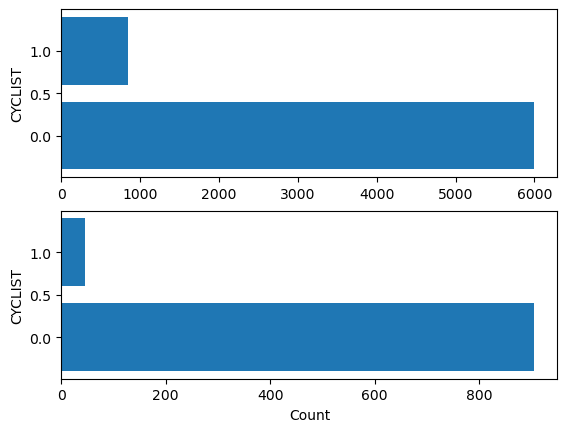

In [16]:
make_summary('CYCLIST')

### Observations
- Cyclist underrepresented in fatalities

,All,Fatal
AUTOMOBILE,,
True,6054,789
False,781,162


,All,Fatal,Delta
AUTOMOBILE,,,
True,0.886,0.83,-0.056
False,0.114,0.17,0.056


chi-square p-value: 0.00000


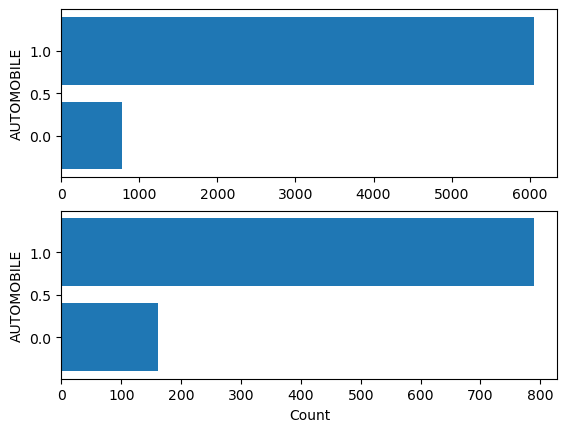

In [17]:
make_summary('AUTOMOBILE')

,All,Fatal
MOTORCYCLE,,
False,6099,849
True,736,102


,All,Fatal,Delta
MOTORCYCLE,,,
False,0.892,0.893,0.001
True,0.108,0.107,-0.001


chi-square p-value: 1.00000


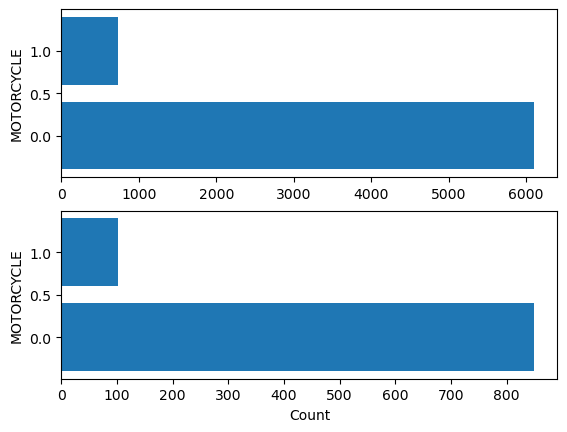

In [18]:
make_summary('MOTORCYCLE')

### Observations
- Marginal differences

,All,Fatal
TRUCK,,
False,6465,844
True,370,107


,All,Fatal,Delta
TRUCK,,,
False,0.946,0.887,-0.059
True,0.054,0.113,0.059


chi-square p-value: 0.00000


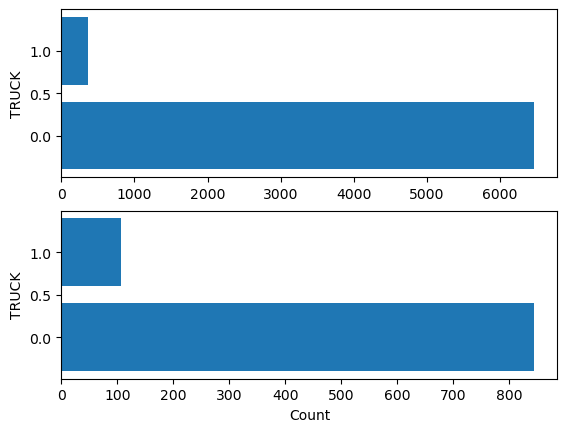

In [19]:
make_summary('TRUCK')

### Observations
- Overrepresented in fatalities

,All,Fatal
TRSN_CITY_VEH,,
False,6475,881
True,360,70


,All,Fatal,Delta
TRSN_CITY_VEH,,,
False,0.947,0.926,-0.021
True,0.053,0.074,0.021


chi-square p-value: 0.01010


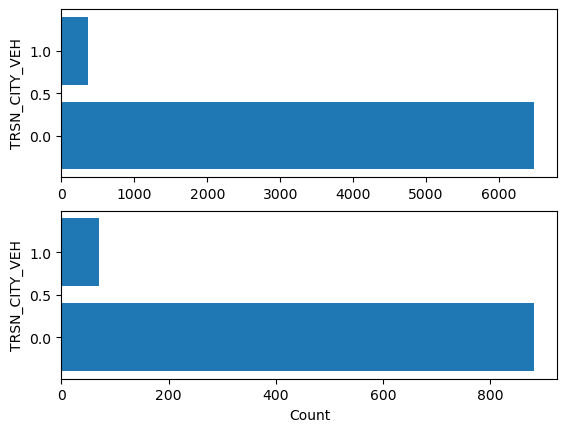

In [20]:
make_summary('TRSN_CITY_VEH')

,All,Fatal
PASSENGER,,
False,5135,726
True,1700,225


,All,Fatal,Delta
PASSENGER,,,
False,0.751,0.763,0.012
True,0.249,0.237,-0.012


chi-square p-value: 0.44007


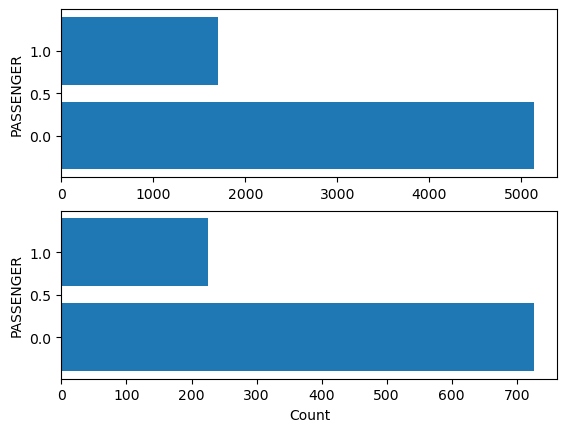

In [21]:
make_summary('PASSENGER')

,All,Fatal
SPEEDING,,
False,5982,767
True,853,184


,All,Fatal,Delta
SPEEDING,,,
False,0.875,0.807,-0.068
True,0.125,0.193,0.068


chi-square p-value: 0.00000


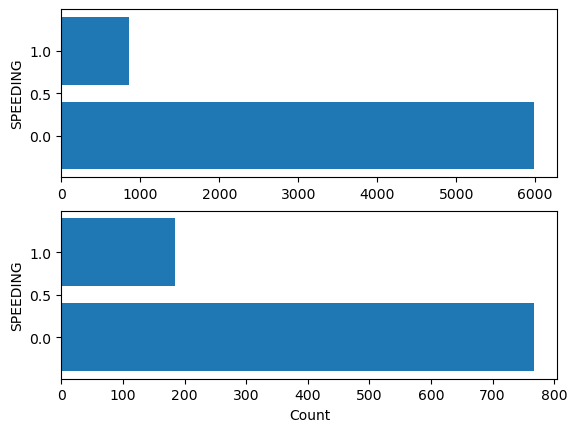

In [22]:
make_summary('SPEEDING')

In [23]:
processed_df.columns

Index(['ROAD_CLASS', 'DISTRICT', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND',
       'ACCLASS', 'IMPACTYPE', 'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE',
       'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER',
       'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY',
       'NEIGHBOURHOOD_158', 'YEAR', 'MONTH_sin', 'MONTH_cos', 'DOW_sin',
       'DOW_cos', 'HOUR_sin', 'HOUR_cos', 'INVAGE_00to04', 'INVAGE_05to09',
       'INVAGE_10to14', 'INVAGE_15to19', 'INVAGE_20to24', 'INVAGE_25to29',
       'INVAGE_30to34', 'INVAGE_35to39', 'INVAGE_40to44', 'INVAGE_45to49',
       'INVAGE_50to54', 'INVAGE_55to59', 'INVAGE_60to64', 'INVAGE_65to69',
       'INVAGE_70to74', 'INVAGE_75to79', 'INVAGE_80to84', 'INVAGE_85to89',
       'INVAGE_90to94', 'INVAGE_Over95', 'INVAGE_unknown', 'NUMPERSONS',
       'MANOEUVER_ChangingLanes', 'MANOEUVER_GoingAhead',
       'MANOEUVER_MakingUTurn', 'MANOEUVER_Merging', 'MANOEUVER_Other',
       'MANOEUVER_Overtaking', 'MANOEUVER_Parked',
       

,All,Fatal
NEAREST_HOSPITAL,,
Unity Health Toronto - St. Joseph's,949,126
Humber River Health - Wilson,937,129
Michael Garron Hospital,632,72
University Health Network - Toronto Western,588,54
Unity Health Toronto - St. Michael's,588,66
Scarborough Health Network - Scarborough General,579,119
William Osler Health System - Etobicoke,484,75
North York General Hospital - General Site,469,65
Scarborough Health Network - Birchmount,431,77


,All,Fatal,Delta
NEAREST_HOSPITAL,,,
Unity Health Toronto - St. Joseph's,0.139,0.132,-0.007
Humber River Health - Wilson,0.137,0.136,-0.001
Michael Garron Hospital,0.092,0.076,-0.016
University Health Network - Toronto Western,0.086,0.057,-0.029
Unity Health Toronto - St. Michael's,0.086,0.069,-0.017
Scarborough Health Network - Scarborough General,0.085,0.125,0.040
William Osler Health System - Etobicoke,0.071,0.079,0.008
North York General Hospital - General Site,0.069,0.068,-0.001
Scarborough Health Network - Birchmount,0.063,0.081,0.018


chi-square p-value: 0.00018


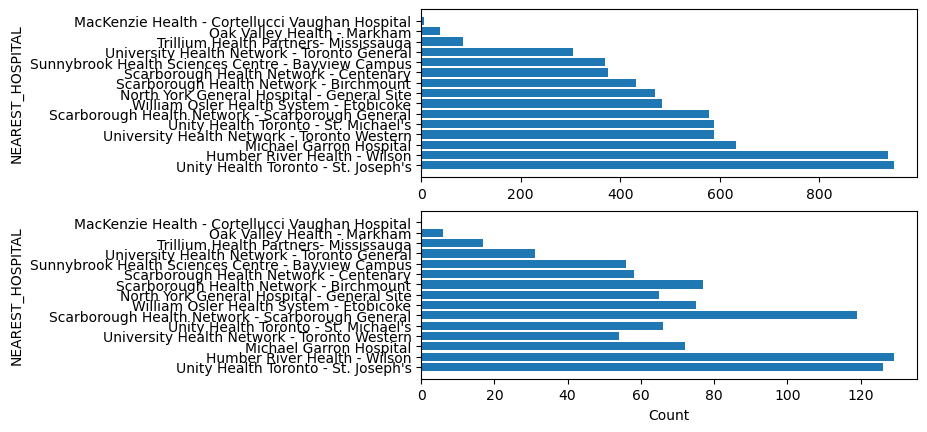

In [30]:
make_summary('NEAREST_HOSPITAL')

In [27]:
processed_df.dtypes.unique()

array([dtype('O'), dtype('bool'), dtype('int64'), dtype('float64')],
      dtype=object)

In [97]:
nonfatal = processed_df.query('ACCLASS != "Fatal"').DIST_TO_HOS
fatal = processed_df.query('ACCLASS == "Fatal"').DIST_TO_HOS
stat, p = ranksums(nonfatal, fatal)
print(f'Wilcoxon rank-sum p-value: {p:.3f}')
print(f'Mean: {nonfatal.mean()}, {fatal.mean()}')
print(f'Median: {nonfatal.median()}, {fatal.median()}')

Wilcoxon rank-sum p-value: 0.007
Mean: 3823.493044279204, 3998.100502617066
Median: 3484.5511824582354, 3738.4845346130896


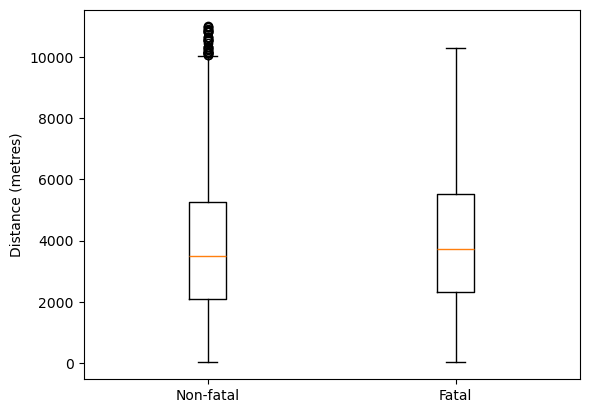

In [99]:
plt.boxplot([nonfatal, fatal], tick_labels=['Non-fatal', 'Fatal'])
plt.ylabel('Distance (metres)')
plt.show()

### Observations
- Significant Differences between groups for Distance to ER ($p=0.007$)